# PINN: Harmonic oscillator

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

## neural net

In [5]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(1, 20) # layers of neural net
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 1)
        
    def forward(self, x):
        out=torch.tanh(self.l1(x)) # does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        out=torch.tanh(self.l4(out))
        out=self.l5(out)
        return out
    

k=1
m=1
def f(net,t): # differential equation loss
    u=net(t)
    #v = torch.autograd.grad(u, t, create_graph=True,grad_outputs=torch.ones_like(u))[0] is the same
    v = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    a = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    
    mse1=nn.MSELoss()
    pt02 = Variable(torch.zeros((100,1)).float(), requires_grad=False).to(device)
    return mse1(k*u+m*a,pt02)

def u_err(net,t0,u0): # initial condition loss (position u0 at time t0)
    u=net(t0)
    mse1=nn.MSELoss()
    return mse1(u,u0)

def u_err_v(net,t0,v0): # initial condition loss (velocity v0 at time t0)
    u=net(t0)
    v0net=torch.autograd.grad(u.sum(), t0, create_graph=True)[0]
    mse1=nn.MSELoss()
    return mse1(v0net,v0)


Using cpu device


## train model

In [11]:

model = NeuralNetwork().to(device)
optimizer=torch.optim.Adam(model.parameters())
for i in range(20000):
    optimizer.zero_grad()
    pt_t_bc = Variable(torch.tensor([[0.0]]).float(), requires_grad=True).to(device) # t boundary condition
    pt_u_bc = Variable(torch.tensor([[0.0]]).float(), requires_grad=False).to(device) # position at t_bc
    pt_v_bc = Variable(torch.tensor([[1.0]]).float(), requires_grad=False).to(device) # velocity at t_bc
    
    loss1=u_err(model,pt_t_bc,pt_u_bc)+u_err_v(model,pt_t_bc,pt_v_bc) #initial condition loss

    t=np.random.rand(100,1)*10.0#*min((3+7.0/10000.0*i),10.0) #collocation points
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    
    loss2=f(model,pt_t) #physics loss
    
    loss = loss1+loss2

    # Backpropagation
    loss.backward()
    optimizer.step()
    print(f'i={i}')
    print(f'loss={loss}')

i=0
loss=1.226560354232788
i=1
loss=1.1745610237121582
i=2
loss=1.1238133907318115
i=3
loss=1.077549934387207
i=4
loss=1.0328893661499023
i=5
loss=0.9912297129631042
i=6
loss=0.9506822824478149
i=7
loss=0.9126860499382019
i=8
loss=0.877294659614563
i=9
loss=0.8426246643066406
i=10
loss=0.8113418221473694
i=11
loss=0.7812146544456482
i=12
loss=0.7531517148017883
i=13
loss=0.7257380485534668
i=14
loss=0.7004654407501221
i=15
loss=0.6769401431083679
i=16
loss=0.6520057916641235
i=17
loss=0.6294482946395874
i=18
loss=0.6083768606185913
i=19
loss=0.5835743546485901
i=20
loss=0.5692445635795593
i=21
loss=0.5409247279167175
i=22
loss=0.5250949263572693
i=23
loss=0.4978620409965515
i=24
loss=0.4893814027309418
i=25
loss=0.4596587121486664
i=26
loss=0.44479334354400635
i=27
loss=0.427127480506897
i=28
loss=0.4164859652519226
i=29
loss=0.40394818782806396
i=30
loss=0.38396549224853516
i=31
loss=0.3691489100456238
i=32
loss=0.36277341842651367
i=33
loss=0.33937013149261475
i=34
loss=0.32926961779

i=302
loss=0.03532510995864868
i=303
loss=0.05338037759065628
i=304
loss=0.055727921426296234
i=305
loss=0.04277603328227997
i=306
loss=0.03616585582494736
i=307
loss=0.04067329689860344
i=308
loss=0.03844500333070755
i=309
loss=0.0345643050968647
i=310
loss=0.043568000197410583
i=311
loss=0.04021928831934929
i=312
loss=0.04510017856955528
i=313
loss=0.03954543173313141
i=314
loss=0.051275137811899185
i=315
loss=0.040792323648929596
i=316
loss=0.045184243470430374
i=317
loss=0.048149168491363525
i=318
loss=0.048284705728292465
i=319
loss=0.04797776788473129
i=320
loss=0.04165085777640343
i=321
loss=0.041859954595565796
i=322
loss=0.05578973516821861
i=323
loss=0.042902495712041855
i=324
loss=0.06401556730270386
i=325
loss=0.04303934425115585
i=326
loss=0.048964980989694595
i=327
loss=0.05145089328289032
i=328
loss=0.04384521394968033
i=329
loss=0.04206407815217972
i=330
loss=0.047513678669929504
i=331
loss=0.0489632710814476
i=332
loss=0.05418282374739647
i=333
loss=0.04242789745330810

i=608
loss=0.024269796907901764
i=609
loss=0.0296932440251112
i=610
loss=0.03558673709630966
i=611
loss=0.027202308177947998
i=612
loss=0.03407542034983635
i=613
loss=0.03012874722480774
i=614
loss=0.027847368270158768
i=615
loss=0.03201187402009964
i=616
loss=0.03334983065724373
i=617
loss=0.030760163441300392
i=618
loss=0.028681360185146332
i=619
loss=0.028444677591323853
i=620
loss=0.03305883705615997
i=621
loss=0.031820449978113174
i=622
loss=0.02935849130153656
i=623
loss=0.03135465830564499
i=624
loss=0.032914064824581146
i=625
loss=0.028522497043013573
i=626
loss=0.032861948013305664
i=627
loss=0.030048619955778122
i=628
loss=0.028939206153154373
i=629
loss=0.021411383524537086
i=630
loss=0.02995944768190384
i=631
loss=0.02741864137351513
i=632
loss=0.03724794462323189
i=633
loss=0.02237810753285885
i=634
loss=0.030161330476403236
i=635
loss=0.030879143625497818
i=636
loss=0.029274526983499527
i=637
loss=0.03469505533576012
i=638
loss=0.030738970264792442
i=639
loss=0.0289698503

i=871
loss=0.033949799835681915
i=872
loss=0.030524590983986855
i=873
loss=0.02226879447698593
i=874
loss=0.03652693331241608
i=875
loss=0.027342796325683594
i=876
loss=0.02794668637216091
i=877
loss=0.027676768600940704
i=878
loss=0.02949368953704834
i=879
loss=0.035329535603523254
i=880
loss=0.028320051729679108
i=881
loss=0.02516488917171955
i=882
loss=0.03477686271071434
i=883
loss=0.036602772772312164
i=884
loss=0.028546174988150597
i=885
loss=0.028439709916710854
i=886
loss=0.03243827819824219
i=887
loss=0.03033318556845188
i=888
loss=0.025662653148174286
i=889
loss=0.034861184656620026
i=890
loss=0.024824248626828194
i=891
loss=0.027303121984004974
i=892
loss=0.0292022917419672
i=893
loss=0.02622741460800171
i=894
loss=0.031475234776735306
i=895
loss=0.031123066321015358
i=896
loss=0.03323954716324806
i=897
loss=0.03070816770195961
i=898
loss=0.027195584028959274
i=899
loss=0.02619193308055401
i=900
loss=0.032678551971912384
i=901
loss=0.024586549028754234
i=902
loss=0.024739937

i=1139
loss=0.0336301289498806
i=1140
loss=0.02435896545648575
i=1141
loss=0.03355523571372032
i=1142
loss=0.0336783267557621
i=1143
loss=0.02825954556465149
i=1144
loss=0.025422053411602974
i=1145
loss=0.031086664646863937
i=1146
loss=0.036462441086769104
i=1147
loss=0.03132930025458336
i=1148
loss=0.02676266059279442
i=1149
loss=0.030345378443598747
i=1150
loss=0.028506461530923843
i=1151
loss=0.030017688870429993
i=1152
loss=0.028553901240229607
i=1153
loss=0.026895606890320778
i=1154
loss=0.030368812382221222
i=1155
loss=0.027078961953520775
i=1156
loss=0.0268243420869112
i=1157
loss=0.027458790689706802
i=1158
loss=0.024809595197439194
i=1159
loss=0.029023321345448494
i=1160
loss=0.027798380702733994
i=1161
loss=0.03453036770224571
i=1162
loss=0.027401980012655258
i=1163
loss=0.026352502405643463
i=1164
loss=0.02891530655324459
i=1165
loss=0.029747851192951202
i=1166
loss=0.02949695475399494
i=1167
loss=0.030039073899388313
i=1168
loss=0.02400815114378929
i=1169
loss=0.02938103675

i=1407
loss=0.026675716042518616
i=1408
loss=0.025349313393235207
i=1409
loss=0.029341932386159897
i=1410
loss=0.031455010175704956
i=1411
loss=0.026487097144126892
i=1412
loss=0.025643441826105118
i=1413
loss=0.024949198588728905
i=1414
loss=0.0254703089594841
i=1415
loss=0.02957950346171856
i=1416
loss=0.025487810373306274
i=1417
loss=0.023758653551340103
i=1418
loss=0.028223363682627678
i=1419
loss=0.023642169311642647
i=1420
loss=0.02507125400006771
i=1421
loss=0.02845085598528385
i=1422
loss=0.030065331608057022
i=1423
loss=0.028504308313131332
i=1424
loss=0.027328073978424072
i=1425
loss=0.023890787735581398
i=1426
loss=0.02576032280921936
i=1427
loss=0.024760408326983452
i=1428
loss=0.026420073583722115
i=1429
loss=0.02170984447002411
i=1430
loss=0.0252845361828804
i=1431
loss=0.02133231982588768
i=1432
loss=0.03177903965115547
i=1433
loss=0.02577747032046318
i=1434
loss=0.03144514933228493
i=1435
loss=0.02621561475098133
i=1436
loss=0.028827255591750145
i=1437
loss=0.0262431968

i=1659
loss=0.027823355048894882
i=1660
loss=0.022403305396437645
i=1661
loss=0.032717976719141006
i=1662
loss=0.024015551432967186
i=1663
loss=0.02713937684893608
i=1664
loss=0.03593559190630913
i=1665
loss=0.026337755843997
i=1666
loss=0.029099466279149055
i=1667
loss=0.03376462310552597
i=1668
loss=0.025678664445877075
i=1669
loss=0.025795994326472282
i=1670
loss=0.025413380935788155
i=1671
loss=0.026356205344200134
i=1672
loss=0.029244959354400635
i=1673
loss=0.024451615288853645
i=1674
loss=0.02353617735207081
i=1675
loss=0.024143749848008156
i=1676
loss=0.032030243426561356
i=1677
loss=0.0244771558791399
i=1678
loss=0.026034172624349594
i=1679
loss=0.02538323774933815
i=1680
loss=0.024013293907046318
i=1681
loss=0.02632984332740307
i=1682
loss=0.02676001936197281
i=1683
loss=0.021741988137364388
i=1684
loss=0.025390280410647392
i=1685
loss=0.02626057341694832
i=1686
loss=0.02236766740679741
i=1687
loss=0.026519622653722763
i=1688
loss=0.022198693826794624
i=1689
loss=0.0270792897

i=1952
loss=0.023822080343961716
i=1953
loss=0.01954515278339386
i=1954
loss=0.02462027594447136
i=1955
loss=0.024681221693754196
i=1956
loss=0.02574090100824833
i=1957
loss=0.025720223784446716
i=1958
loss=0.02393004484474659
i=1959
loss=0.020047862082719803
i=1960
loss=0.024959813803434372
i=1961
loss=0.021260906010866165
i=1962
loss=0.024124514311552048
i=1963
loss=0.026469601318240166
i=1964
loss=0.02089150808751583
i=1965
loss=0.022270310670137405
i=1966
loss=0.0275418683886528
i=1967
loss=0.020045123994350433
i=1968
loss=0.026999928057193756
i=1969
loss=0.02639680728316307
i=1970
loss=0.02372199110686779
i=1971
loss=0.021803854033350945
i=1972
loss=0.022505750879645348
i=1973
loss=0.02153797075152397
i=1974
loss=0.026664238423109055
i=1975
loss=0.022511383518576622
i=1976
loss=0.022020848467946053
i=1977
loss=0.017568476498126984
i=1978
loss=0.022367775440216064
i=1979
loss=0.02118414081633091
i=1980
loss=0.021470066159963608
i=1981
loss=0.023059610277414322
i=1982
loss=0.0207028

i=2205
loss=0.025137998163700104
i=2206
loss=0.01918124407529831
i=2207
loss=0.02600780688226223
i=2208
loss=0.020175648853182793
i=2209
loss=0.01972826197743416
i=2210
loss=0.021908652037382126
i=2211
loss=0.019998786970973015
i=2212
loss=0.02217067964375019
i=2213
loss=0.021627632901072502
i=2214
loss=0.019214371219277382
i=2215
loss=0.022194422781467438
i=2216
loss=0.0179346464574337
i=2217
loss=0.02327720634639263
i=2218
loss=0.020547987893223763
i=2219
loss=0.025906965136528015
i=2220
loss=0.018557952716946602
i=2221
loss=0.023687059059739113
i=2222
loss=0.01862109825015068
i=2223
loss=0.026710648089647293
i=2224
loss=0.020621569827198982
i=2225
loss=0.021720850840210915
i=2226
loss=0.021323123946785927
i=2227
loss=0.022208217531442642
i=2228
loss=0.020152218639850616
i=2229
loss=0.02196887694299221
i=2230
loss=0.0180828794836998
i=2231
loss=0.020235542207956314
i=2232
loss=0.020424144342541695
i=2233
loss=0.02199780009686947
i=2234
loss=0.02019466832280159
i=2235
loss=0.020965794

i=2497
loss=0.024169836193323135
i=2498
loss=0.021976523101329803
i=2499
loss=0.017557363957166672
i=2500
loss=0.021737324073910713
i=2501
loss=0.01945250667631626
i=2502
loss=0.018860336393117905
i=2503
loss=0.020383073017001152
i=2504
loss=0.017433132976293564
i=2505
loss=0.016340196132659912
i=2506
loss=0.01655503548681736
i=2507
loss=0.01659499667584896
i=2508
loss=0.018123380839824677
i=2509
loss=0.01916198804974556
i=2510
loss=0.01711375080049038
i=2511
loss=0.019278623163700104
i=2512
loss=0.019259590655565262
i=2513
loss=0.017342617735266685
i=2514
loss=0.019772417843341827
i=2515
loss=0.016540849581360817
i=2516
loss=0.017275989055633545
i=2517
loss=0.019122647121548653
i=2518
loss=0.015164065174758434
i=2519
loss=0.017062967643141747
i=2520
loss=0.016158917918801308
i=2521
loss=0.01662508025765419
i=2522
loss=0.016188818961381912
i=2523
loss=0.02020094357430935
i=2524
loss=0.017529940232634544
i=2525
loss=0.01824929378926754
i=2526
loss=0.017152953892946243
i=2527
loss=0.0219

i=2765
loss=0.019935905933380127
i=2766
loss=0.01602700911462307
i=2767
loss=0.016230646520853043
i=2768
loss=0.01576763018965721
i=2769
loss=0.018934356048703194
i=2770
loss=0.015437381342053413
i=2771
loss=0.019574005156755447
i=2772
loss=0.014754027128219604
i=2773
loss=0.015117743983864784
i=2774
loss=0.01545936893671751
i=2775
loss=0.015099876560270786
i=2776
loss=0.019968926906585693
i=2777
loss=0.015430813655257225
i=2778
loss=0.01391384657472372
i=2779
loss=0.017305871471762657
i=2780
loss=0.018041962757706642
i=2781
loss=0.01593165472149849
i=2782
loss=0.015108549036085606
i=2783
loss=0.018738867715001106
i=2784
loss=0.017875095829367638
i=2785
loss=0.01690712384879589
i=2786
loss=0.01721201092004776
i=2787
loss=0.015382950194180012
i=2788
loss=0.01613495871424675
i=2789
loss=0.0170720424503088
i=2790
loss=0.01689314842224121
i=2791
loss=0.017553193494677544
i=2792
loss=0.01936766318976879
i=2793
loss=0.016645729541778564
i=2794
loss=0.015698349103331566
i=2795
loss=0.01561386

i=3026
loss=0.015115896239876747
i=3027
loss=0.014717083424329758
i=3028
loss=0.013253377750515938
i=3029
loss=0.013069169595837593
i=3030
loss=0.014895851723849773
i=3031
loss=0.013195103965699673
i=3032
loss=0.015322948805987835
i=3033
loss=0.015720296651124954
i=3034
loss=0.016452163457870483
i=3035
loss=0.013024825602769852
i=3036
loss=0.015122199431061745
i=3037
loss=0.01717301644384861
i=3038
loss=0.015379943884909153
i=3039
loss=0.015705585479736328
i=3040
loss=0.01489030010998249
i=3041
loss=0.013852560892701149
i=3042
loss=0.015580539591610432
i=3043
loss=0.015188440680503845
i=3044
loss=0.016878733411431313
i=3045
loss=0.014356128871440887
i=3046
loss=0.014031633734703064
i=3047
loss=0.015586398541927338
i=3048
loss=0.014637716114521027
i=3049
loss=0.014364163391292095
i=3050
loss=0.01647031307220459
i=3051
loss=0.015605911612510681
i=3052
loss=0.015443781390786171
i=3053
loss=0.015635399147868156
i=3054
loss=0.016457146033644676
i=3055
loss=0.015748418867588043
i=3056
loss=0

i=3294
loss=0.012145807035267353
i=3295
loss=0.012322355061769485
i=3296
loss=0.013777370564639568
i=3297
loss=0.01400150079280138
i=3298
loss=0.012703374028205872
i=3299
loss=0.015135044232010841
i=3300
loss=0.013851042836904526
i=3301
loss=0.012768433429300785
i=3302
loss=0.011602592654526234
i=3303
loss=0.012829610146582127
i=3304
loss=0.011770726181566715
i=3305
loss=0.013114018365740776
i=3306
loss=0.015218693763017654
i=3307
loss=0.014421461150050163
i=3308
loss=0.011343692429363728
i=3309
loss=0.017545776441693306
i=3310
loss=0.011369329877197742
i=3311
loss=0.013447960838675499
i=3312
loss=0.013979615643620491
i=3313
loss=0.013435653410851955
i=3314
loss=0.01566717028617859
i=3315
loss=0.01503734476864338
i=3316
loss=0.01623551920056343
i=3317
loss=0.014004127122461796
i=3318
loss=0.016161931678652763
i=3319
loss=0.013566992245614529
i=3320
loss=0.012922530062496662
i=3321
loss=0.013467996381223202
i=3322
loss=0.015198687091469765
i=3323
loss=0.012631338089704514
i=3324
loss=0.

i=3559
loss=0.011896928772330284
i=3560
loss=0.01076897419989109
i=3561
loss=0.01351963635534048
i=3562
loss=0.013761380687355995
i=3563
loss=0.010133658535778522
i=3564
loss=0.018948489800095558
i=3565
loss=0.01305550616234541
i=3566
loss=0.016351381316781044
i=3567
loss=0.013102486729621887
i=3568
loss=0.014149006456136703
i=3569
loss=0.01460481807589531
i=3570
loss=0.014732946641743183
i=3571
loss=0.021196581423282623
i=3572
loss=0.01143770944327116
i=3573
loss=0.014841143041849136
i=3574
loss=0.011796802282333374
i=3575
loss=0.013734552077949047
i=3576
loss=0.011422800831496716
i=3577
loss=0.012190527282655239
i=3578
loss=0.012314141727983952
i=3579
loss=0.01653520204126835
i=3580
loss=0.012929003685712814
i=3581
loss=0.014990460127592087
i=3582
loss=0.014254966750741005
i=3583
loss=0.015844684094190598
i=3584
loss=0.015000264160335064
i=3585
loss=0.013965652324259281
i=3586
loss=0.014472713693976402
i=3587
loss=0.013799423351883888
i=3588
loss=0.014576062560081482
i=3589
loss=0.01

i=3837
loss=0.013178382068872452
i=3838
loss=0.012767761014401913
i=3839
loss=0.010994795709848404
i=3840
loss=0.012189415283501148
i=3841
loss=0.01122706662863493
i=3842
loss=0.012099524028599262
i=3843
loss=0.01082725077867508
i=3844
loss=0.011088795959949493
i=3845
loss=0.011971400119364262
i=3846
loss=0.01144157163798809
i=3847
loss=0.013836048543453217
i=3848
loss=0.011122156865894794
i=3849
loss=0.013980904594063759
i=3850
loss=0.012190771289169788
i=3851
loss=0.014096214435994625
i=3852
loss=0.011931396089494228
i=3853
loss=0.010919550433754921
i=3854
loss=0.014406785368919373
i=3855
loss=0.011291210539638996
i=3856
loss=0.01300794631242752
i=3857
loss=0.012975645251572132
i=3858
loss=0.011179456487298012
i=3859
loss=0.013573544099926949
i=3860
loss=0.012814916670322418
i=3861
loss=0.012285965494811535
i=3862
loss=0.012514076195657253
i=3863
loss=0.014965127222239971
i=3864
loss=0.011524229310452938
i=3865
loss=0.013050842098891735
i=3866
loss=0.014028765261173248
i=3867
loss=0.

i=4115
loss=0.011757053434848785
i=4116
loss=0.01541185099631548
i=4117
loss=0.012737688608467579
i=4118
loss=0.01758909411728382
i=4119
loss=0.01186777837574482
i=4120
loss=0.015530839562416077
i=4121
loss=0.011489677242934704
i=4122
loss=0.013229592703282833
i=4123
loss=0.015446790494024754
i=4124
loss=0.015239419415593147
i=4125
loss=0.015520424582064152
i=4126
loss=0.011794599704444408
i=4127
loss=0.015742545947432518
i=4128
loss=0.01141840685158968
i=4129
loss=0.016224810853600502
i=4130
loss=0.012493805028498173
i=4131
loss=0.01253947988152504
i=4132
loss=0.011043332517147064
i=4133
loss=0.01249219011515379
i=4134
loss=0.012963561341166496
i=4135
loss=0.01569436676800251
i=4136
loss=0.013404416851699352
i=4137
loss=0.012709613889455795
i=4138
loss=0.012550611048936844
i=4139
loss=0.014298563823103905
i=4140
loss=0.011077703908085823
i=4141
loss=0.020468270406126976
i=4142
loss=0.010393664240837097
i=4143
loss=0.012686329893767834
i=4144
loss=0.01334000751376152
i=4145
loss=0.0124

i=4384
loss=0.012530531734228134
i=4385
loss=0.012337848544120789
i=4386
loss=0.012474579736590385
i=4387
loss=0.012254016473889351
i=4388
loss=0.010237258858978748
i=4389
loss=0.009493938647210598
i=4390
loss=0.010536073707044125
i=4391
loss=0.010835138149559498
i=4392
loss=0.01210915669798851
i=4393
loss=0.01361850369721651
i=4394
loss=0.011234255507588387
i=4395
loss=0.014856946654617786
i=4396
loss=0.01184377446770668
i=4397
loss=0.012983879074454308
i=4398
loss=0.012202941812574863
i=4399
loss=0.011943378485739231
i=4400
loss=0.012154731899499893
i=4401
loss=0.01331388857215643
i=4402
loss=0.012225300073623657
i=4403
loss=0.011474310420453548
i=4404
loss=0.010393865406513214
i=4405
loss=0.011876012198626995
i=4406
loss=0.010727734304964542
i=4407
loss=0.012995156459510326
i=4408
loss=0.009739769622683525
i=4409
loss=0.008873921819031239
i=4410
loss=0.012265252880752087
i=4411
loss=0.010678193531930447
i=4412
loss=0.010645925998687744
i=4413
loss=0.011801701970398426
i=4414
loss=0.

i=4652
loss=0.011434917338192463
i=4653
loss=0.012059860862791538
i=4654
loss=0.011278856545686722
i=4655
loss=0.011900361627340317
i=4656
loss=0.012844051234424114
i=4657
loss=0.010678465478122234
i=4658
loss=0.013292697258293629
i=4659
loss=0.01043147873133421
i=4660
loss=0.012975766323506832
i=4661
loss=0.012860536575317383
i=4662
loss=0.011420072056353092
i=4663
loss=0.013397828675806522
i=4664
loss=0.010929231531918049
i=4665
loss=0.014310445636510849
i=4666
loss=0.010624373331665993
i=4667
loss=0.013452654704451561
i=4668
loss=0.011281036771833897
i=4669
loss=0.012645488604903221
i=4670
loss=0.008400393649935722
i=4671
loss=0.015363589860498905
i=4672
loss=0.01143792923539877
i=4673
loss=0.015049159526824951
i=4674
loss=0.00883570034056902
i=4675
loss=0.014128011651337147
i=4676
loss=0.011488239280879498
i=4677
loss=0.010138759389519691
i=4678
loss=0.010223297402262688
i=4679
loss=0.011455729603767395
i=4680
loss=0.0106580825522542
i=4681
loss=0.009807934984564781
i=4682
loss=0.0

i=4940
loss=0.012755108997225761
i=4941
loss=0.01016117911785841
i=4942
loss=0.011914330534636974
i=4943
loss=0.010423936881124973
i=4944
loss=0.00951166357845068
i=4945
loss=0.010414890944957733
i=4946
loss=0.013383036479353905
i=4947
loss=0.008521586656570435
i=4948
loss=0.011952251195907593
i=4949
loss=0.010610061697661877
i=4950
loss=0.011832717806100845
i=4951
loss=0.0099607203155756
i=4952
loss=0.01089817937463522
i=4953
loss=0.011328675784170628
i=4954
loss=0.010922231711447239
i=4955
loss=0.011340631172060966
i=4956
loss=0.011155533604323864
i=4957
loss=0.00949006900191307
i=4958
loss=0.011248617433011532
i=4959
loss=0.01179992314428091
i=4960
loss=0.012919955886900425
i=4961
loss=0.011685168370604515
i=4962
loss=0.011541535146534443
i=4963
loss=0.010930614545941353
i=4964
loss=0.011414949782192707
i=4965
loss=0.012458277866244316
i=4966
loss=0.011291422881186008
i=4967
loss=0.01308388076722622
i=4968
loss=0.013710816390812397
i=4969
loss=0.01104054320603609
i=4970
loss=0.01231

i=5227
loss=0.010144694708287716
i=5228
loss=0.009999142959713936
i=5229
loss=0.013132622465491295
i=5230
loss=0.012699335813522339
i=5231
loss=0.010492295026779175
i=5232
loss=0.012418803758919239
i=5233
loss=0.011445571668446064
i=5234
loss=0.009909084998071194
i=5235
loss=0.010561158880591393
i=5236
loss=0.010352304205298424
i=5237
loss=0.00802826788276434
i=5238
loss=0.012462949380278587
i=5239
loss=0.009713507257401943
i=5240
loss=0.010610115714371204
i=5241
loss=0.009005340747535229
i=5242
loss=0.009363763965666294
i=5243
loss=0.011408133432269096
i=5244
loss=0.011308757588267326
i=5245
loss=0.010607280768454075
i=5246
loss=0.009668550454080105
i=5247
loss=0.010683264583349228
i=5248
loss=0.009578686207532883
i=5249
loss=0.013167071156203747
i=5250
loss=0.010584384202957153
i=5251
loss=0.015205834992229939
i=5252
loss=0.011776790954172611
i=5253
loss=0.011354722082614899
i=5254
loss=0.010217198170721531
i=5255
loss=0.009928888641297817
i=5256
loss=0.009424158371984959
i=5257
loss

i=5513
loss=0.01437657792121172
i=5514
loss=0.011334304697811604
i=5515
loss=0.015187020413577557
i=5516
loss=0.011649487540125847
i=5517
loss=0.014122513122856617
i=5518
loss=0.009366149082779884
i=5519
loss=0.011824461631476879
i=5520
loss=0.009929627180099487
i=5521
loss=0.011083750985562801
i=5522
loss=0.01046202052384615
i=5523
loss=0.00854520220309496
i=5524
loss=0.011549526825547218
i=5525
loss=0.009507785551249981
i=5526
loss=0.010842490941286087
i=5527
loss=0.009552660398185253
i=5528
loss=0.010995864868164062
i=5529
loss=0.00805428996682167
i=5530
loss=0.012248313054442406
i=5531
loss=0.010804574936628342
i=5532
loss=0.008806699886918068
i=5533
loss=0.009482224471867085
i=5534
loss=0.01338975504040718
i=5535
loss=0.009871285408735275
i=5536
loss=0.009488227777183056
i=5537
loss=0.009694002568721771
i=5538
loss=0.00981743074953556
i=5539
loss=0.00984219741076231
i=5540
loss=0.010726643726229668
i=5541
loss=0.010069136507809162
i=5542
loss=0.010636796243488789
i=5543
loss=0.010

i=5806
loss=0.009975173510611057
i=5807
loss=0.012166145257651806
i=5808
loss=0.009323298931121826
i=5809
loss=0.010179173201322556
i=5810
loss=0.011895771138370037
i=5811
loss=0.012015428394079208
i=5812
loss=0.010849302634596825
i=5813
loss=0.011414054781198502
i=5814
loss=0.01181049644947052
i=5815
loss=0.013154082000255585
i=5816
loss=0.012819631025195122
i=5817
loss=0.012767227366566658
i=5818
loss=0.013322148472070694
i=5819
loss=0.011210097000002861
i=5820
loss=0.009996037930250168
i=5821
loss=0.010473649948835373
i=5822
loss=0.011536456644535065
i=5823
loss=0.01106103602796793
i=5824
loss=0.010193266905844212
i=5825
loss=0.013130140490829945
i=5826
loss=0.01021395530551672
i=5827
loss=0.013548715971410275
i=5828
loss=0.010238800197839737
i=5829
loss=0.01540181040763855
i=5830
loss=0.010570296086370945
i=5831
loss=0.012187745422124863
i=5832
loss=0.011995523236691952
i=5833
loss=0.013439282774925232
i=5834
loss=0.011435268446803093
i=5835
loss=0.01204039715230465
i=5836
loss=0.0

i=6092
loss=0.01273035816848278
i=6093
loss=0.011710086837410927
i=6094
loss=0.011387456208467484
i=6095
loss=0.010167327709496021
i=6096
loss=0.011675440706312656
i=6097
loss=0.01245830301195383
i=6098
loss=0.010039075277745724
i=6099
loss=0.009720616973936558
i=6100
loss=0.010173491202294827
i=6101
loss=0.009631771594285965
i=6102
loss=0.009584425017237663
i=6103
loss=0.010263587348163128
i=6104
loss=0.010839457623660564
i=6105
loss=0.008708483539521694
i=6106
loss=0.01126859150826931
i=6107
loss=0.010197634808719158
i=6108
loss=0.011113663204014301
i=6109
loss=0.010898440144956112
i=6110
loss=0.010038838721811771
i=6111
loss=0.009857740253210068
i=6112
loss=0.011478140018880367
i=6113
loss=0.010225174017250538
i=6114
loss=0.010792441666126251
i=6115
loss=0.009557696059346199
i=6116
loss=0.013036862015724182
i=6117
loss=0.009315954521298409
i=6118
loss=0.012921871617436409
i=6119
loss=0.010418549180030823
i=6120
loss=0.015478920191526413
i=6121
loss=0.010134212672710419
i=6122
loss=0

i=6368
loss=0.008936050347983837
i=6369
loss=0.008736962452530861
i=6370
loss=0.010075606405735016
i=6371
loss=0.009658356197178364
i=6372
loss=0.009742959402501583
i=6373
loss=0.010207980871200562
i=6374
loss=0.009909837506711483
i=6375
loss=0.009254999458789825
i=6376
loss=0.01027973648160696
i=6377
loss=0.009260004386305809
i=6378
loss=0.009671967476606369
i=6379
loss=0.009184950962662697
i=6380
loss=0.011009620502591133
i=6381
loss=0.008330556564033031
i=6382
loss=0.009197383187711239
i=6383
loss=0.012485168874263763
i=6384
loss=0.010134304873645306
i=6385
loss=0.010613598860800266
i=6386
loss=0.009597991593182087
i=6387
loss=0.01132907159626484
i=6388
loss=0.009277918376028538
i=6389
loss=0.009000659920275211
i=6390
loss=0.010408544912934303
i=6391
loss=0.009726634249091148
i=6392
loss=0.009780428372323513
i=6393
loss=0.011061491444706917
i=6394
loss=0.01081869937479496
i=6395
loss=0.008454736322164536
i=6396
loss=0.011554907076060772
i=6397
loss=0.008494000881910324
i=6398
loss=0

i=6639
loss=0.010159719735383987
i=6640
loss=0.009438344277441502
i=6641
loss=0.010507574304938316
i=6642
loss=0.010562281124293804
i=6643
loss=0.011363313533365726
i=6644
loss=0.009762916713953018
i=6645
loss=0.010503517463803291
i=6646
loss=0.008785517886281013
i=6647
loss=0.008799443021416664
i=6648
loss=0.008258634246885777
i=6649
loss=0.008289569057524204
i=6650
loss=0.009890921413898468
i=6651
loss=0.007784195244312286
i=6652
loss=0.008371829986572266
i=6653
loss=0.010757367126643658
i=6654
loss=0.009983030147850513
i=6655
loss=0.009984218515455723
i=6656
loss=0.009900114499032497
i=6657
loss=0.009874855168163776
i=6658
loss=0.008937233127653599
i=6659
loss=0.010088825598359108
i=6660
loss=0.008843401446938515
i=6661
loss=0.008087734691798687
i=6662
loss=0.008545069955289364
i=6663
loss=0.01105036772787571
i=6664
loss=0.011302039958536625
i=6665
loss=0.011811675503849983
i=6666
loss=0.01036263071000576
i=6667
loss=0.014928009361028671
i=6668
loss=0.011340142227709293
i=6669
loss=

i=6923
loss=0.0096505181863904
i=6924
loss=0.008833954110741615
i=6925
loss=0.011145506054162979
i=6926
loss=0.00900850910693407
i=6927
loss=0.01096522156149149
i=6928
loss=0.010921919718384743
i=6929
loss=0.007962103001773357
i=6930
loss=0.009670295752584934
i=6931
loss=0.009648336097598076
i=6932
loss=0.010883279144763947
i=6933
loss=0.009349058382213116
i=6934
loss=0.010162287391722202
i=6935
loss=0.008217216469347477
i=6936
loss=0.009061584249138832
i=6937
loss=0.010901565663516521
i=6938
loss=0.009636041708290577
i=6939
loss=0.011524063535034657
i=6940
loss=0.009524079971015453
i=6941
loss=0.007963611744344234
i=6942
loss=0.010180732235312462
i=6943
loss=0.008294775150716305
i=6944
loss=0.010605236515402794
i=6945
loss=0.009551353752613068
i=6946
loss=0.008702605962753296
i=6947
loss=0.008011856116354465
i=6948
loss=0.006781305652111769
i=6949
loss=0.008995870128273964
i=6950
loss=0.008628678508102894
i=6951
loss=0.009141883812844753
i=6952
loss=0.010343477129936218
i=6953
loss=0.

i=7207
loss=0.008927080780267715
i=7208
loss=0.012800713069736958
i=7209
loss=0.011084653437137604
i=7210
loss=0.014426358975470066
i=7211
loss=0.008306911215186119
i=7212
loss=0.011641077697277069
i=7213
loss=0.009494241327047348
i=7214
loss=0.012737203389406204
i=7215
loss=0.010123476386070251
i=7216
loss=0.01103410217911005
i=7217
loss=0.009629013948142529
i=7218
loss=0.010385393165051937
i=7219
loss=0.008715609088540077
i=7220
loss=0.012371093966066837
i=7221
loss=0.008054250851273537
i=7222
loss=0.010233258828520775
i=7223
loss=0.009587865322828293
i=7224
loss=0.010699696838855743
i=7225
loss=0.00844733789563179
i=7226
loss=0.009568312205374241
i=7227
loss=0.01164538599550724
i=7228
loss=0.01083278376609087
i=7229
loss=0.0138176204636693
i=7230
loss=0.008147360756993294
i=7231
loss=0.011995373293757439
i=7232
loss=0.009011441841721535
i=7233
loss=0.012209681794047356
i=7234
loss=0.00932631641626358
i=7235
loss=0.008608612231910229
i=7236
loss=0.008614987134933472
i=7237
loss=0.008

i=7509
loss=0.007199487648904324
i=7510
loss=0.009690762497484684
i=7511
loss=0.010379632003605366
i=7512
loss=0.008048671297729015
i=7513
loss=0.009723590686917305
i=7514
loss=0.008560237474739552
i=7515
loss=0.00995161198079586
i=7516
loss=0.006275758612900972
i=7517
loss=0.007638829294592142
i=7518
loss=0.00952280405908823
i=7519
loss=0.008844026364386082
i=7520
loss=0.009490194730460644
i=7521
loss=0.006397019140422344
i=7522
loss=0.008501684293150902
i=7523
loss=0.007663107942789793
i=7524
loss=0.00829688273370266
i=7525
loss=0.008651592768728733
i=7526
loss=0.008464398793876171
i=7527
loss=0.007790825795382261
i=7528
loss=0.007557541131973267
i=7529
loss=0.009011799469590187
i=7530
loss=0.00820308830589056
i=7531
loss=0.010624456219375134
i=7532
loss=0.007470885757356882
i=7533
loss=0.00879746861755848
i=7534
loss=0.007130015641450882
i=7535
loss=0.00919051468372345
i=7536
loss=0.009946577250957489
i=7537
loss=0.009452149271965027
i=7538
loss=0.010509776882827282
i=7539
loss=0.00

i=7796
loss=0.008044127374887466
i=7797
loss=0.01000562496483326
i=7798
loss=0.007670445833355188
i=7799
loss=0.009158412925899029
i=7800
loss=0.006760872900485992
i=7801
loss=0.0090571828186512
i=7802
loss=0.005761819891631603
i=7803
loss=0.008600333705544472
i=7804
loss=0.00670230807736516
i=7805
loss=0.009843314997851849
i=7806
loss=0.008207864128053188
i=7807
loss=0.010797574184834957
i=7808
loss=0.008665294386446476
i=7809
loss=0.009478320367634296
i=7810
loss=0.007796014659106731
i=7811
loss=0.008171644061803818
i=7812
loss=0.009051889181137085
i=7813
loss=0.007817870937287807
i=7814
loss=0.01074131764471531
i=7815
loss=0.007166987285017967
i=7816
loss=0.010362191125750542
i=7817
loss=0.009356717579066753
i=7818
loss=0.007642319891601801
i=7819
loss=0.010764564387500286
i=7820
loss=0.012811570428311825
i=7821
loss=0.007475358434021473
i=7822
loss=0.009072914719581604
i=7823
loss=0.008034326136112213
i=7824
loss=0.008575040847063065
i=7825
loss=0.008684379048645496
i=7826
loss=0.0

i=8091
loss=0.008646273985505104
i=8092
loss=0.007915176451206207
i=8093
loss=0.006750479806214571
i=8094
loss=0.007536786608397961
i=8095
loss=0.005683239549398422
i=8096
loss=0.0073540546000003815
i=8097
loss=0.006492841523140669
i=8098
loss=0.006331599783152342
i=8099
loss=0.007732281927019358
i=8100
loss=0.0065222871489822865
i=8101
loss=0.007317434065043926
i=8102
loss=0.006613005418330431
i=8103
loss=0.006765434984117746
i=8104
loss=0.0077979653142392635
i=8105
loss=0.01301337406039238
i=8106
loss=0.009976381435990334
i=8107
loss=0.008522376418113708
i=8108
loss=0.006849419325590134
i=8109
loss=0.009678151458501816
i=8110
loss=0.009422232396900654
i=8111
loss=0.00604722835123539
i=8112
loss=0.00719457445666194
i=8113
loss=0.007114504463970661
i=8114
loss=0.006936588324606419
i=8115
loss=0.007123829331248999
i=8116
loss=0.007387728430330753
i=8117
loss=0.005823030602186918
i=8118
loss=0.010015304200351238
i=8119
loss=0.006761221215128899
i=8120
loss=0.009834520518779755
i=8121
los

i=8365
loss=0.0062006511725485325
i=8366
loss=0.008705241605639458
i=8367
loss=0.006175360642373562
i=8368
loss=0.00637122243642807
i=8369
loss=0.00723670469596982
i=8370
loss=0.00631306366994977
i=8371
loss=0.006008100230246782
i=8372
loss=0.00627267686650157
i=8373
loss=0.00529850460588932
i=8374
loss=0.006510496139526367
i=8375
loss=0.005379321984946728
i=8376
loss=0.005574881564825773
i=8377
loss=0.005440594628453255
i=8378
loss=0.006095395423471928
i=8379
loss=0.008072102442383766
i=8380
loss=0.007050978485494852
i=8381
loss=0.005305777303874493
i=8382
loss=0.0058034430257976055
i=8383
loss=0.005324485711753368
i=8384
loss=0.008294938132166862
i=8385
loss=0.006534910295158625
i=8386
loss=0.0061537702567875385
i=8387
loss=0.004968912806361914
i=8388
loss=0.005010618828237057
i=8389
loss=0.006635098718106747
i=8390
loss=0.005591004621237516
i=8391
loss=0.005944902077317238
i=8392
loss=0.007173971738666296
i=8393
loss=0.0055923061445355415
i=8394
loss=0.0068993400782346725
i=8395
los

i=8649
loss=0.007630904205143452
i=8650
loss=0.004272616468369961
i=8651
loss=0.004580214153975248
i=8652
loss=0.004070112481713295
i=8653
loss=0.003670217702165246
i=8654
loss=0.006311011966317892
i=8655
loss=0.005857615731656551
i=8656
loss=0.004725422244518995
i=8657
loss=0.004949354100972414
i=8658
loss=0.004721490666270256
i=8659
loss=0.0037525861989706755
i=8660
loss=0.005450701806694269
i=8661
loss=0.005211929325014353
i=8662
loss=0.005123737268149853
i=8663
loss=0.004913865588605404
i=8664
loss=0.005863378290086985
i=8665
loss=0.006520300172269344
i=8666
loss=0.005632528103888035
i=8667
loss=0.0035323689226061106
i=8668
loss=0.005471117794513702
i=8669
loss=0.004316662438213825
i=8670
loss=0.005302396137267351
i=8671
loss=0.004989572335034609
i=8672
loss=0.006854027044028044
i=8673
loss=0.005070219747722149
i=8674
loss=0.006732205860316753
i=8675
loss=0.004373153671622276
i=8676
loss=0.005656222812831402
i=8677
loss=0.006200209725648165
i=8678
loss=0.010222216136753559
i=8679
l

i=8930
loss=0.005906168837100267
i=8931
loss=0.005265288054943085
i=8932
loss=0.003411094658076763
i=8933
loss=0.0056266384199261665
i=8934
loss=0.0034048676025122404
i=8935
loss=0.00485575944185257
i=8936
loss=0.0066231670789420605
i=8937
loss=0.005414680577814579
i=8938
loss=0.004367486573755741
i=8939
loss=0.0037176210898905993
i=8940
loss=0.004837854765355587
i=8941
loss=0.004773789085447788
i=8942
loss=0.004580780863761902
i=8943
loss=0.004707620944827795
i=8944
loss=0.004261708818376064
i=8945
loss=0.003996201790869236
i=8946
loss=0.007026087027043104
i=8947
loss=0.004680761136114597
i=8948
loss=0.004724799655377865
i=8949
loss=0.005540441256016493
i=8950
loss=0.005399614572525024
i=8951
loss=0.0035489583387970924
i=8952
loss=0.007424090523272753
i=8953
loss=0.007277100346982479
i=8954
loss=0.003322988050058484
i=8955
loss=0.007203239947557449
i=8956
loss=0.006178218871355057
i=8957
loss=0.003598147304728627
i=8958
loss=0.004073782358318567
i=8959
loss=0.0038412718567997217
i=896

i=9221
loss=0.0024632285349071026
i=9222
loss=0.005207844544202089
i=9223
loss=0.0033790897578001022
i=9224
loss=0.003383679548278451
i=9225
loss=0.0036749658174812794
i=9226
loss=0.003089052392169833
i=9227
loss=0.003307374194264412
i=9228
loss=0.003110392251983285
i=9229
loss=0.0035739068407565355
i=9230
loss=0.003277050331234932
i=9231
loss=0.003654970321804285
i=9232
loss=0.003378279972821474
i=9233
loss=0.0032194219529628754
i=9234
loss=0.003895461093634367
i=9235
loss=0.004593691322952509
i=9236
loss=0.0032378104515373707
i=9237
loss=0.0068269516341388226
i=9238
loss=0.003072331426665187
i=9239
loss=0.004659347701817751
i=9240
loss=0.0034519860055297613
i=9241
loss=0.0025199700612574816
i=9242
loss=0.003409324213862419
i=9243
loss=0.0038816274609416723
i=9244
loss=0.0025008053053170443
i=9245
loss=0.003976378124207258
i=9246
loss=0.0028309400659054518
i=9247
loss=0.003544972976669669
i=9248
loss=0.004279714543372393
i=9249
loss=0.002851467113941908
i=9250
loss=0.00418649055063724

i=9502
loss=0.0049594989977777
i=9503
loss=0.0033787412103265524
i=9504
loss=0.0036329622380435467
i=9505
loss=0.003590469481423497
i=9506
loss=0.002044359687715769
i=9507
loss=0.0021100861486047506
i=9508
loss=0.0032131776679307222
i=9509
loss=0.004169966094195843
i=9510
loss=0.0026809296105057
i=9511
loss=0.002825284143909812
i=9512
loss=0.0024932012893259525
i=9513
loss=0.003460382344201207
i=9514
loss=0.0028500822372734547
i=9515
loss=0.0032245542388409376
i=9516
loss=0.003705692943185568
i=9517
loss=0.002785533433780074
i=9518
loss=0.003999550361186266
i=9519
loss=0.0018501072190701962
i=9520
loss=0.004535927437245846
i=9521
loss=0.003980040084570646
i=9522
loss=0.0037780837155878544
i=9523
loss=0.002018062397837639
i=9524
loss=0.00363118015229702
i=9525
loss=0.0020563153084367514
i=9526
loss=0.00415430311113596
i=9527
loss=0.0026216835249215364
i=9528
loss=0.003896593116223812
i=9529
loss=0.003535866504535079
i=9530
loss=0.0029163770377635956
i=9531
loss=0.004409072920680046
i=95

i=9795
loss=0.0010641110129654408
i=9796
loss=0.001886168960481882
i=9797
loss=0.001263459911569953
i=9798
loss=0.0019524042727425694
i=9799
loss=0.002403433434665203
i=9800
loss=0.00204592477530241
i=9801
loss=0.001547750667668879
i=9802
loss=0.0017985497834160924
i=9803
loss=0.002513093175366521
i=9804
loss=0.002990476554259658
i=9805
loss=0.0030830567702651024
i=9806
loss=0.001782231847755611
i=9807
loss=0.0016278744442388415
i=9808
loss=0.0034258270170539618
i=9809
loss=0.002326598158106208
i=9810
loss=0.004633293487131596
i=9811
loss=0.001749951159581542
i=9812
loss=0.004562715999782085
i=9813
loss=0.0036492825020104647
i=9814
loss=0.0015949585940688848
i=9815
loss=0.0033145335037261248
i=9816
loss=0.0021569833625108004
i=9817
loss=0.0025516643654555082
i=9818
loss=0.001845991238951683
i=9819
loss=0.0038202074356377125
i=9820
loss=0.0020641288720071316
i=9821
loss=0.002724096179008484
i=9822
loss=0.0014446425484493375
i=9823
loss=0.0019289975753054023
i=9824
loss=0.002051306422799

i=10086
loss=0.0018523557810112834
i=10087
loss=0.001900048810057342
i=10088
loss=0.002677415730431676
i=10089
loss=0.0014395511243492365
i=10090
loss=0.0012028934434056282
i=10091
loss=0.0018770125461742282
i=10092
loss=0.00309141818434
i=10093
loss=0.0019129235297441483
i=10094
loss=0.0018592366250231862
i=10095
loss=0.0017069156747311354
i=10096
loss=0.0028239788953214884
i=10097
loss=0.0007194416248239577
i=10098
loss=0.0046896249987185
i=10099
loss=0.002356418641284108
i=10100
loss=0.0009910777444019914
i=10101
loss=0.002333442447707057
i=10102
loss=0.0012501347810029984
i=10103
loss=0.0018695996841415763
i=10104
loss=0.0007694621453993022
i=10105
loss=0.002395221032202244
i=10106
loss=0.0016271142521873116
i=10107
loss=0.0014870746526867151
i=10108
loss=0.0013106409460306168
i=10109
loss=0.0014696139842271805
i=10110
loss=0.001964189112186432
i=10111
loss=0.001472808187827468
i=10112
loss=0.001658326480537653
i=10113
loss=0.0014345557428896427
i=10114
loss=0.0024759508669376373
i

i=10323
loss=0.001014444511383772
i=10324
loss=0.00048049879842437804
i=10325
loss=0.0012053840328007936
i=10326
loss=0.0008317515603266656
i=10327
loss=0.0007477979524992406
i=10328
loss=0.0011982456780970097
i=10329
loss=0.00028724956791847944
i=10330
loss=0.002198203234001994
i=10331
loss=0.0012700464576482773
i=10332
loss=0.0009217034094035625
i=10333
loss=0.0011790212010964751
i=10334
loss=0.0009344581631012261
i=10335
loss=0.0015673814341425896
i=10336
loss=0.0010117589263245463
i=10337
loss=0.0006040749722160399
i=10338
loss=0.0013603271218016744
i=10339
loss=0.000592572265304625
i=10340
loss=0.0008024587295949459
i=10341
loss=0.000639504985883832
i=10342
loss=0.0009163281065411866
i=10343
loss=0.0006802704301662743
i=10344
loss=0.00028851989191025496
i=10345
loss=0.0008861190872266889
i=10346
loss=0.0012531979009509087
i=10347
loss=0.00043437432032078505
i=10348
loss=0.0011654049158096313
i=10349
loss=0.001398189109750092
i=10350
loss=0.0010882325004786253
i=10351
loss=0.000859

i=10564
loss=0.000385225226636976
i=10565
loss=0.0011209046933799982
i=10566
loss=0.0008489937172271311
i=10567
loss=0.0007647416787222028
i=10568
loss=0.0011663668556138873
i=10569
loss=0.0007261646678671241
i=10570
loss=0.0010871277190744877
i=10571
loss=0.0007772747194394469
i=10572
loss=0.00045371311716735363
i=10573
loss=0.0006364883738569915
i=10574
loss=0.000702274905052036
i=10575
loss=0.0005234894342720509
i=10576
loss=0.0012764924904331565
i=10577
loss=0.0013064072700217366
i=10578
loss=0.0011171145597472787
i=10579
loss=0.00045761786168441176
i=10580
loss=0.0011928239837288857
i=10581
loss=0.0008324179798364639
i=10582
loss=0.0006512387772090733
i=10583
loss=0.001293584587983787
i=10584
loss=0.0005964919691905379
i=10585
loss=0.001085972529835999
i=10586
loss=0.00042185309575870633
i=10587
loss=0.0003255555930081755
i=10588
loss=0.0010473914444446564
i=10589
loss=0.0006862138980068266
i=10590
loss=0.0012281471863389015
i=10591
loss=0.0009648919804021716
i=10592
loss=0.000630

i=10800
loss=0.0006193260778672993
i=10801
loss=0.0007687246543355286
i=10802
loss=0.0006147328531369567
i=10803
loss=0.0005638730362989008
i=10804
loss=0.0005341720534488559
i=10805
loss=0.0005019980599172413
i=10806
loss=0.0005910479230806231
i=10807
loss=0.0006257654167711735
i=10808
loss=0.0003942854527849704
i=10809
loss=0.0004266225441824645
i=10810
loss=0.0003856188559439033
i=10811
loss=0.00032177261891774833
i=10812
loss=0.00032358471071347594
i=10813
loss=0.000491528247948736
i=10814
loss=0.0004547037242446095
i=10815
loss=0.0003448078059591353
i=10816
loss=0.0004679804260376841
i=10817
loss=0.0005093450308777392
i=10818
loss=0.0007069518323987722
i=10819
loss=0.0004168546001892537
i=10820
loss=0.00047594591160304844
i=10821
loss=0.0003381466958671808
i=10822
loss=0.00042050337651744485
i=10823
loss=0.0004905689274892211
i=10824
loss=0.00031805410981178284
i=10825
loss=0.0006459485739469528
i=10826
loss=0.0004956391057930887
i=10827
loss=0.0010191031033173203
i=10828
loss=0.0

i=11039
loss=0.0004903912777081132
i=11040
loss=0.0004298320855014026
i=11041
loss=0.0005014893831685185
i=11042
loss=0.0005742817302234471
i=11043
loss=0.0004021285567432642
i=11044
loss=0.0003383419243618846
i=11045
loss=0.0007760352455079556
i=11046
loss=0.00048402626998722553
i=11047
loss=0.0005969799822196364
i=11048
loss=0.0007550599402748048
i=11049
loss=0.0003869431675411761
i=11050
loss=0.000675620511174202
i=11051
loss=0.00040983123471960425
i=11052
loss=0.0005921951378695667
i=11053
loss=0.0005988560151308775
i=11054
loss=0.0006168006802909076
i=11055
loss=0.00027090581716038287
i=11056
loss=0.0003329510800540447
i=11057
loss=0.0005611373344436288
i=11058
loss=0.00040960629121400416
i=11059
loss=0.0005198459257371724
i=11060
loss=0.0006764077115803957
i=11061
loss=0.00039548828499391675
i=11062
loss=0.000582198437768966
i=11063
loss=0.00048469207831658423
i=11064
loss=0.00027491524815559387
i=11065
loss=0.00034931377740576863
i=11066
loss=0.00047351352986879647
i=11067
loss=

i=11277
loss=0.0005340821808204055
i=11278
loss=0.0003569919499568641
i=11279
loss=0.0005269419052638113
i=11280
loss=0.0008200002484954894
i=11281
loss=0.00034920594771392643
i=11282
loss=0.0005637526046484709
i=11283
loss=0.0003307865699753165
i=11284
loss=0.0006471030064858496
i=11285
loss=0.0011161573929712176
i=11286
loss=0.00048299608170054853
i=11287
loss=0.0005052368505857885
i=11288
loss=0.0006308062002062798
i=11289
loss=0.0003777086385525763
i=11290
loss=0.0006652881857007742
i=11291
loss=0.0005783197120763361
i=11292
loss=0.00037185123073868454
i=11293
loss=0.000568767951335758
i=11294
loss=0.00034646375570446253
i=11295
loss=0.00025200119125656784
i=11296
loss=0.0002214487176388502
i=11297
loss=0.0005169041687622666
i=11298
loss=0.0011903912527486682
i=11299
loss=0.001605384866707027
i=11300
loss=0.0006665853434242308
i=11301
loss=0.000618879625108093
i=11302
loss=0.0003475709818303585
i=11303
loss=0.000289254094241187
i=11304
loss=0.00023617992701474577
i=11305
loss=0.000

i=11514
loss=0.0002475017390679568
i=11515
loss=0.00020686625794041902
i=11516
loss=0.0002220546011812985
i=11517
loss=0.00036086360341869295
i=11518
loss=0.0003145844384562224
i=11519
loss=0.0003285737184341997
i=11520
loss=0.00020896374189760536
i=11521
loss=0.0001601890253368765
i=11522
loss=0.0004191651241853833
i=11523
loss=0.0003656710614450276
i=11524
loss=0.0002961849677376449
i=11525
loss=0.00027416308876127005
i=11526
loss=0.00031598025816492736
i=11527
loss=0.0002252556587336585
i=11528
loss=0.0001872619177447632
i=11529
loss=0.0004420593613758683
i=11530
loss=0.00026328544481657445
i=11531
loss=0.0001925493124872446
i=11532
loss=0.0002592218806967139
i=11533
loss=0.00031261207186616957
i=11534
loss=0.00015288987196981907
i=11535
loss=0.0001637304958421737
i=11536
loss=0.00031427302747033536
i=11537
loss=0.00033764049294404685
i=11538
loss=0.00026268395595252514
i=11539
loss=0.0003606731188483536
i=11540
loss=0.00020500041136983782
i=11541
loss=0.0003040227456949651
i=11542


i=11752
loss=0.0005222111358307302
i=11753
loss=0.00044997301301918924
i=11754
loss=0.0002207405777880922
i=11755
loss=0.00036018903483636677
i=11756
loss=0.000729200488422066
i=11757
loss=0.00022932676074560732
i=11758
loss=0.0006440613651648164
i=11759
loss=0.0012464241590350866
i=11760
loss=0.0007636291556991637
i=11761
loss=0.00024488838971592486
i=11762
loss=0.0004381902690511197
i=11763
loss=0.000482848787214607
i=11764
loss=0.00015861816063988954
i=11765
loss=0.00038134472561068833
i=11766
loss=0.0008559850975871086
i=11767
loss=0.0006273604230955243
i=11768
loss=0.00016169525042641908
i=11769
loss=0.0008185852784663439
i=11770
loss=0.0011675858404487371
i=11771
loss=0.0010075389873236418
i=11772
loss=0.00037878192961215973
i=11773
loss=0.0006326966104097664
i=11774
loss=0.000982239143922925
i=11775
loss=0.0004329904622863978
i=11776
loss=0.0009208490373566747
i=11777
loss=0.0014775280142202973
i=11778
loss=0.0007276539108715951
i=11779
loss=0.00015107012586668134
i=11780
loss=0

i=11990
loss=0.0010567972203716636
i=11991
loss=0.0003489145601633936
i=11992
loss=0.0002679818426258862
i=11993
loss=0.0006976614240556955
i=11994
loss=0.0007061827345751226
i=11995
loss=0.00023580789275001734
i=11996
loss=0.00036020067636854947
i=11997
loss=0.0003599623159971088
i=11998
loss=0.0002538925036787987
i=11999
loss=0.00021577294683083892
i=12000
loss=0.00014246517093852162
i=12001
loss=0.0003030178777407855
i=12002
loss=0.00011062993144150823
i=12003
loss=0.00030865430017001927
i=12004
loss=0.0004359964223112911
i=12005
loss=0.00036473103682510555
i=12006
loss=0.00016911311831790954
i=12007
loss=0.0003454229445196688
i=12008
loss=0.00014506034494843334
i=12009
loss=0.0002663515624590218
i=12010
loss=0.00037966304807923734
i=12011
loss=0.00021151764667592943
i=12012
loss=0.00026109081227332354
i=12013
loss=0.0006206858088262379
i=12014
loss=0.00025929382536560297
i=12015
loss=0.00024126512289512902
i=12016
loss=0.0005775463068857789
i=12017
loss=0.00117838429287076
i=12018


i=12228
loss=0.000257318519288674
i=12229
loss=0.000272395001957193
i=12230
loss=0.0005420963279902935
i=12231
loss=0.0004960905644111335
i=12232
loss=0.00022876053117215633
i=12233
loss=0.0003917737049050629
i=12234
loss=0.001125018228776753
i=12235
loss=0.0008148515480570495
i=12236
loss=0.0003692923637572676
i=12237
loss=0.00032779265893623233
i=12238
loss=0.00022921038907952607
i=12239
loss=0.000119615244329907
i=12240
loss=0.00010731588554335758
i=12241
loss=0.0001229833869729191
i=12242
loss=0.0001964875846169889
i=12243
loss=0.00019310822244733572
i=12244
loss=0.00016438894090242684
i=12245
loss=9.547657100483775e-05
i=12246
loss=0.00011056304356316105
i=12247
loss=0.00023842160589993
i=12248
loss=0.00030430013430304825
i=12249
loss=0.00017769790429156274
i=12250
loss=0.00016335285909008235
i=12251
loss=0.00013484737428370863
i=12252
loss=0.0003711925237439573
i=12253
loss=0.0009991105180233717
i=12254
loss=0.0007640819530934095
i=12255
loss=0.00026676352717913687
i=12256
loss=0

i=12513
loss=0.00047779359738342464
i=12514
loss=0.0001427049282938242
i=12515
loss=0.0004207053279969841
i=12516
loss=0.0012961990432813764
i=12517
loss=0.0010485074017196894
i=12518
loss=0.00025075089070014656
i=12519
loss=0.0005673650302924216
i=12520
loss=0.002140045864507556
i=12521
loss=0.003149001393467188
i=12522
loss=0.0026488089933991432
i=12523
loss=0.000809252611361444
i=12524
loss=0.00010217550152447075
i=12525
loss=0.0008318917825818062
i=12526
loss=0.0015036083059385419
i=12527
loss=0.000528994423802942
i=12528
loss=0.00020644099276978523
i=12529
loss=0.0010238172253593802
i=12530
loss=0.001277807168662548
i=12531
loss=0.0007073545712046325
i=12532
loss=0.00024117478460539132
i=12533
loss=0.0001360400638077408
i=12534
loss=0.00026996529777534306
i=12535
loss=0.0002735357847996056
i=12536
loss=0.00027948879869654775
i=12537
loss=0.00023649643117096275
i=12538
loss=0.0005614421097561717
i=12539
loss=0.0007849167450331151
i=12540
loss=0.0005460870452225208
i=12541
loss=0.00

i=12746
loss=0.00011187991185579449
i=12747
loss=0.00011528863979037851
i=12748
loss=9.603854414308444e-05
i=12749
loss=0.00018994379206560552
i=12750
loss=0.000236541498452425
i=12751
loss=0.0005271174595691264
i=12752
loss=0.0007284631137736142
i=12753
loss=0.000793742947280407
i=12754
loss=0.0005328714614734054
i=12755
loss=0.0002442130644340068
i=12756
loss=0.0001616199588170275
i=12757
loss=0.0005429533775895834
i=12758
loss=0.000833907863125205
i=12759
loss=0.0002793361200019717
i=12760
loss=0.00013755762483924627
i=12761
loss=0.0006036695558577776
i=12762
loss=0.0008726916275918484
i=12763
loss=0.0006302146357484162
i=12764
loss=0.0002196210843976587
i=12765
loss=0.00014702684711664915
i=12766
loss=0.00016836427676025778
i=12767
loss=0.00023032927128951997
i=12768
loss=0.00025534999440424144
i=12769
loss=0.00022898979659657925
i=12770
loss=0.0002190604282077402
i=12771
loss=8.96588753676042e-05
i=12772
loss=8.822690142551437e-05
i=12773
loss=0.0002524958981666714
i=12774
loss=0.

i=13032
loss=9.602453792467713e-05
i=13033
loss=0.00011440939124440774
i=13034
loss=0.00013136508641764522
i=13035
loss=3.821711288765073e-05
i=13036
loss=0.00015338373486883938
i=13037
loss=5.037877053837292e-05
i=13038
loss=0.00011736010492313653
i=13039
loss=8.481351687805727e-05
i=13040
loss=0.00011201959569007158
i=13041
loss=6.814867811044678e-05
i=13042
loss=5.14995408593677e-05
i=13043
loss=8.699156751390547e-05
i=13044
loss=0.0001959168876055628
i=13045
loss=0.00018295919289812446
i=13046
loss=0.00014634184481110424
i=13047
loss=0.00011569874186534435
i=13048
loss=0.0002937645185738802
i=13049
loss=0.0001959149376489222
i=13050
loss=5.1443315896904096e-05
i=13051
loss=0.00017872927128337324
i=13052
loss=0.00019007179071195424
i=13053
loss=0.00013182598922867328
i=13054
loss=0.00019657019583974034
i=13055
loss=0.00013666042650584131
i=13056
loss=0.00016862095799297094
i=13057
loss=6.491814565379173e-05
i=13058
loss=0.0001424618239980191
i=13059
loss=9.45563951972872e-05
i=13060

i=13318
loss=0.0001765187771525234
i=13319
loss=9.645311365602538e-05
i=13320
loss=0.0005489737377502024
i=13321
loss=0.0006664845859631896
i=13322
loss=0.00021068190108053386
i=13323
loss=0.0002624825283419341
i=13324
loss=0.0010832641273736954
i=13325
loss=0.001420477987267077
i=13326
loss=0.0003771319752559066
i=13327
loss=0.00022266914311330765
i=13328
loss=0.0014094207435846329
i=13329
loss=0.0012135786237195134
i=13330
loss=0.0001226959575433284
i=13331
loss=0.0005474802455864847
i=13332
loss=0.0015257515478879213
i=13333
loss=0.0008305455558001995
i=13334
loss=4.1237253753934056e-05
i=13335
loss=0.0007717468542978168
i=13336
loss=0.0012819680850952864
i=13337
loss=0.0008767242543399334
i=13338
loss=0.00012271272134967148
i=13339
loss=0.0007644226425327361
i=13340
loss=0.00105188915040344
i=13341
loss=0.0003865465405397117
i=13342
loss=0.00015941544552333653
i=13343
loss=0.0007509058341383934
i=13344
loss=0.0006730983150191605
i=13345
loss=8.671029354445636e-05
i=13346
loss=0.000

i=13607
loss=4.730223008664325e-05
i=13608
loss=0.0003041486779693514
i=13609
loss=0.0005704570794478059
i=13610
loss=0.0004156975483056158
i=13611
loss=7.063336670398712e-05
i=13612
loss=0.00016096842591650784
i=13613
loss=0.0005772433360107243
i=13614
loss=0.0007352600805461407
i=13615
loss=0.0001614168577361852
i=13616
loss=0.0001830966502893716
i=13617
loss=0.0008518875692971051
i=13618
loss=0.0006799454567953944
i=13619
loss=0.00014999292034190148
i=13620
loss=0.0001108712749555707
i=13621
loss=0.0003873191017191857
i=13622
loss=0.0002891548501793295
i=13623
loss=0.00010746176121756434
i=13624
loss=6.740691605955362e-05
i=13625
loss=0.00014209983055479825
i=13626
loss=7.67414749134332e-05
i=13627
loss=9.62948688538745e-05
i=13628
loss=0.00016081002831924707
i=13629
loss=0.00012102226901333779
i=13630
loss=4.677198739955202e-05
i=13631
loss=4.312424425734207e-05
i=13632
loss=1.959582914423663e-05
i=13633
loss=0.00010884726361837238
i=13634
loss=0.00016593547479715198
i=13635
loss=0

i=13886
loss=0.00038225832395255566
i=13887
loss=0.0006161521305330098
i=13888
loss=0.000790678896009922
i=13889
loss=0.0008957997197285295
i=13890
loss=0.0004247547476552427
i=13891
loss=0.00010864187788683921
i=13892
loss=0.00010234244109597057
i=13893
loss=0.0005629541119560599
i=13894
loss=0.001448331167921424
i=13895
loss=0.0025021417532116175
i=13896
loss=0.002401210367679596
i=13897
loss=0.0009952003601938486
i=13898
loss=4.7474331950070336e-05
i=13899
loss=0.0006714501068927348
i=13900
loss=0.0013444398064166307
i=13901
loss=0.0007030630367808044
i=13902
loss=0.0002657499862834811
i=13903
loss=5.007292566006072e-05
i=13904
loss=0.00016738768317736685
i=13905
loss=0.0003426465846132487
i=13906
loss=0.0004303103778511286
i=13907
loss=0.0003966311924159527
i=13908
loss=0.00012315536150708795
i=13909
loss=7.27279984857887e-05
i=13910
loss=0.00039693774306215346
i=13911
loss=0.0010494645684957504
i=13912
loss=0.0008485815487802029
i=13913
loss=0.00020723827765323222
i=13914
loss=8.2

i=14168
loss=0.00020582917204592377
i=14169
loss=0.00025098526384681463
i=14170
loss=0.00020243925973773003
i=14171
loss=0.0001392607664456591
i=14172
loss=1.2071302990079857e-05
i=14173
loss=0.00012042302114423364
i=14174
loss=0.0003420640714466572
i=14175
loss=0.0008460935205221176
i=14176
loss=0.0010805140482261777
i=14177
loss=0.0012105194618925452
i=14178
loss=0.001924731070175767
i=14179
loss=0.001276761176995933
i=14180
loss=0.0004815650172531605
i=14181
loss=8.191782399080694e-05
i=14182
loss=0.0003300410171505064
i=14183
loss=0.0009242615196853876
i=14184
loss=0.0012197847245261073
i=14185
loss=0.0013034417061135173
i=14186
loss=0.0009290036396123469
i=14187
loss=0.00029439362697303295
i=14188
loss=0.00010041422501672059
i=14189
loss=0.0003489601076580584
i=14190
loss=0.0009434496751055121
i=14191
loss=0.0012837827671319246
i=14192
loss=0.0014212314272299409
i=14193
loss=0.0012245558900758624
i=14194
loss=0.0010054601589217782
i=14195
loss=0.0005941546987742186
i=14196
loss=0.

i=14456
loss=9.087669604923576e-05
i=14457
loss=0.00025445816572755575
i=14458
loss=0.0002289223048137501
i=14459
loss=3.4319724363740534e-05
i=14460
loss=9.028148633660749e-05
i=14461
loss=0.00019685199367813766
i=14462
loss=0.00027689337730407715
i=14463
loss=0.0001227227912750095
i=14464
loss=9.64145438047126e-05
i=14465
loss=0.0002579482679720968
i=14466
loss=0.00017203469178639352
i=14467
loss=6.035644037183374e-05
i=14468
loss=5.937091918895021e-05
i=14469
loss=0.00014034818741492927
i=14470
loss=3.1816744012758136e-05
i=14471
loss=7.917211769381538e-05
i=14472
loss=0.00011120682756882161
i=14473
loss=5.6265591410920024e-05
i=14474
loss=5.0209804612677544e-05
i=14475
loss=0.00022468596580438316
i=14476
loss=0.0001993213954847306
i=14477
loss=3.1134677556110546e-05
i=14478
loss=0.00019808352226391435
i=14479
loss=0.00016054116713348776
i=14480
loss=7.660781557206064e-05
i=14481
loss=3.690756784635596e-05
i=14482
loss=8.292500569950789e-05
i=14483
loss=3.3537122362758964e-05
i=1448

i=14699
loss=3.021249722223729e-05
i=14700
loss=8.738619362702593e-05
i=14701
loss=0.00011489455937407911
i=14702
loss=0.0001321015297435224
i=14703
loss=4.129610533709638e-05
i=14704
loss=2.458555536577478e-05
i=14705
loss=1.397873984387843e-05
i=14706
loss=5.4561864089919254e-05
i=14707
loss=4.049477865919471e-05
i=14708
loss=1.1934875146835111e-05
i=14709
loss=1.2608680663106497e-05
i=14710
loss=1.3035893971391488e-05
i=14711
loss=1.870836604211945e-05
i=14712
loss=1.4401821317733265e-05
i=14713
loss=2.0159375708317384e-05
i=14714
loss=2.0443640096345916e-05
i=14715
loss=6.383521395036951e-05
i=14716
loss=0.00012181179772596806
i=14717
loss=0.00023437094932887703
i=14718
loss=0.0002726417442318052
i=14719
loss=0.00017415026377420872
i=14720
loss=3.272955655120313e-05
i=14721
loss=4.8460107791470364e-05
i=14722
loss=0.0002638522710185498
i=14723
loss=0.0003919586888514459
i=14724
loss=0.00037429158692248166
i=14725
loss=4.556488784146495e-05
i=14726
loss=0.00017375116294715554
i=1472

i=14938
loss=6.259026849875227e-05
i=14939
loss=2.1083928004372865e-05
i=14940
loss=6.61424855934456e-05
i=14941
loss=7.20276657375507e-05
i=14942
loss=8.1156576925423e-05
i=14943
loss=2.016656071646139e-05
i=14944
loss=5.254113057162613e-05
i=14945
loss=0.0001258023694390431
i=14946
loss=0.00015891791554167867
i=14947
loss=0.00011236336285946891
i=14948
loss=2.0491459508775733e-05
i=14949
loss=3.853261296171695e-05
i=14950
loss=0.00010396922880318016
i=14951
loss=9.634114394430071e-05
i=14952
loss=5.04377530887723e-05
i=14953
loss=1.9179940863978118e-05
i=14954
loss=3.4104341466445476e-05
i=14955
loss=6.124393257778138e-05
i=14956
loss=7.748971984256059e-05
i=14957
loss=6.815231608925387e-05
i=14958
loss=4.614968565874733e-05
i=14959
loss=2.783859963528812e-05
i=14960
loss=1.04426835605409e-05
i=14961
loss=2.0925384887959808e-05
i=14962
loss=2.3363403670373373e-05
i=14963
loss=2.8216927603352815e-05
i=14964
loss=2.2202440959517844e-05
i=14965
loss=1.9925530068576336e-05
i=14966
loss=5

i=15173
loss=0.0004544671974144876
i=15174
loss=0.0002843729453161359
i=15175
loss=0.00017580499115865678
i=15176
loss=0.00018879849812947214
i=15177
loss=6.27471599727869e-05
i=15178
loss=6.701864185743034e-05
i=15179
loss=0.0001178913953481242
i=15180
loss=8.60393192851916e-05
i=15181
loss=8.69626528583467e-05
i=15182
loss=4.3953208660241216e-05
i=15183
loss=3.81154750357382e-05
i=15184
loss=4.1200204577762634e-05
i=15185
loss=6.690038571832702e-05
i=15186
loss=5.5140655604191124e-05
i=15187
loss=2.7757800125982612e-05
i=15188
loss=7.455082959495485e-05
i=15189
loss=0.00013925443636253476
i=15190
loss=0.0002691411355044693
i=15191
loss=0.00035376971936784685
i=15192
loss=0.00019608778529800475
i=15193
loss=4.1479153878754005e-05
i=15194
loss=4.0188264392782e-05
i=15195
loss=0.00013092831068206578
i=15196
loss=9.4961142167449e-05
i=15197
loss=6.875366671010852e-05
i=15198
loss=1.2100624189770315e-05
i=15199
loss=3.659915819298476e-05
i=15200
loss=6.428477354347706e-05
i=15201
loss=9.6

i=15455
loss=2.1360916434787214e-05
i=15456
loss=2.2807518689660355e-05
i=15457
loss=1.1171647201990709e-05
i=15458
loss=1.4868908692733385e-05
i=15459
loss=8.084518412942998e-06
i=15460
loss=1.2003947631455958e-05
i=15461
loss=1.30456983242766e-05
i=15462
loss=1.5017990335763898e-05
i=15463
loss=1.107353818952106e-05
i=15464
loss=9.981206858356018e-06
i=15465
loss=1.2312520084378775e-05
i=15466
loss=1.6595842680544592e-05
i=15467
loss=2.5031633413163945e-05
i=15468
loss=4.3541927880141884e-05
i=15469
loss=5.274812792777084e-05
i=15470
loss=4.550273297354579e-05
i=15471
loss=6.108972684160108e-06
i=15472
loss=2.6956227884511463e-05
i=15473
loss=3.767700764001347e-05
i=15474
loss=3.476761412457563e-05
i=15475
loss=1.0792232387757394e-05
i=15476
loss=2.0709723685286008e-05
i=15477
loss=1.5267994967871346e-05
i=15478
loss=1.5942059690132737e-05
i=15479
loss=3.509572343318723e-05
i=15480
loss=5.150356810190715e-05
i=15481
loss=3.9213020500028506e-05
i=15482
loss=1.9200399037799798e-05
i=15

i=15690
loss=0.00013995431072544307
i=15691
loss=0.00011110996274510399
i=15692
loss=7.226988964248449e-05
i=15693
loss=7.483799709007144e-05
i=15694
loss=2.9687627829844132e-05
i=15695
loss=1.9780240108957514e-05
i=15696
loss=2.68650364887435e-05
i=15697
loss=1.4805041246290784e-05
i=15698
loss=2.1664192900061607e-05
i=15699
loss=9.817304999160115e-06
i=15700
loss=3.4669898013817146e-05
i=15701
loss=4.66156707261689e-05
i=15702
loss=4.20122523792088e-05
i=15703
loss=4.051454016007483e-05
i=15704
loss=3.516786819091067e-05
i=15705
loss=2.1708838175982237e-05
i=15706
loss=9.848698937275913e-06
i=15707
loss=1.6798654542071745e-05
i=15708
loss=1.4023261428519618e-05
i=15709
loss=2.293131547048688e-05
i=15710
loss=2.450534884701483e-05
i=15711
loss=1.918433918035589e-05
i=15712
loss=1.3460752597893588e-05
i=15713
loss=1.0335080332879443e-05
i=15714
loss=3.1851657695369795e-05
i=15715
loss=3.561445191735402e-05
i=15716
loss=2.1550888050114736e-05
i=15717
loss=1.6651949408696964e-05
i=15718


i=15928
loss=1.933868770720437e-05
i=15929
loss=2.7364098059479147e-05
i=15930
loss=2.0750678231706843e-05
i=15931
loss=3.695834311656654e-05
i=15932
loss=4.157730654696934e-05
i=15933
loss=1.4200836631061975e-05
i=15934
loss=2.9331387850106694e-05
i=15935
loss=2.5629404262872413e-05
i=15936
loss=2.4275163013953716e-05
i=15937
loss=4.111410089535639e-05
i=15938
loss=2.3537924789707176e-05
i=15939
loss=2.9985885703354143e-05
i=15940
loss=3.0397808586712927e-05
i=15941
loss=1.53704677359201e-05
i=15942
loss=3.97905932914e-05
i=15943
loss=4.717617775895633e-05
i=15944
loss=2.320152816537302e-05
i=15945
loss=3.560038021532819e-05
i=15946
loss=3.0111770684015937e-05
i=15947
loss=2.813996616168879e-05
i=15948
loss=6.275394116528332e-05
i=15949
loss=5.9438913012854755e-05
i=15950
loss=2.1206151359365322e-05
i=15951
loss=2.3381364371743985e-05
i=15952
loss=4.4380529288901016e-05
i=15953
loss=2.597018283267971e-05
i=15954
loss=2.3877057174104266e-05
i=15955
loss=4.180639371043071e-05
i=15956
lo

i=16163
loss=1.97272402147064e-05
i=16164
loss=7.954468856041785e-06
i=16165
loss=1.1092474778706674e-05
i=16166
loss=1.786605571396649e-05
i=16167
loss=1.0163277693209238e-05
i=16168
loss=1.1579082638490945e-05
i=16169
loss=1.813898234104272e-05
i=16170
loss=2.2937325411476195e-05
i=16171
loss=1.0209707397734746e-05
i=16172
loss=2.121587203873787e-05
i=16173
loss=1.6081741705420427e-05
i=16174
loss=1.0656464837666135e-05
i=16175
loss=6.267008302529575e-06
i=16176
loss=1.5272538803401403e-05
i=16177
loss=1.4018848560226616e-05
i=16178
loss=2.089994086418301e-05
i=16179
loss=5.419795797934057e-06
i=16180
loss=7.739845386822708e-06
i=16181
loss=9.819884326134343e-06
i=16182
loss=2.2205205823411234e-05
i=16183
loss=6.4300520534743555e-06
i=16184
loss=1.2904565664939582e-05
i=16185
loss=9.259979378839489e-06
i=16186
loss=1.0540850780671462e-05
i=16187
loss=1.1824153261841275e-05
i=16188
loss=2.3447813873644918e-05
i=16189
loss=1.7336613382212818e-05
i=16190
loss=1.9691031411639415e-05
i=16

i=16398
loss=5.555910320254043e-05
i=16399
loss=7.629659376107156e-05
i=16400
loss=9.108538506552577e-06
i=16401
loss=4.86679891764652e-05
i=16402
loss=9.519633022136986e-05
i=16403
loss=0.0001011836138786748
i=16404
loss=6.047288843546994e-05
i=16405
loss=1.733644603518769e-05
i=16406
loss=1.8591612388263457e-05
i=16407
loss=6.183030927786604e-05
i=16408
loss=6.854242383269593e-05
i=16409
loss=3.9884118450572714e-05
i=16410
loss=2.0437699276953936e-05
i=16411
loss=3.362350616953336e-05
i=16412
loss=9.617420437280089e-05
i=16413
loss=7.71759296185337e-05
i=16414
loss=1.4819564967183396e-05
i=16415
loss=7.888276741141453e-05
i=16416
loss=0.0001902853837236762
i=16417
loss=0.0003090393729507923
i=16418
loss=0.00040626918780617416
i=16419
loss=0.00019414826238062233
i=16420
loss=3.9669586840318516e-05
i=16421
loss=8.823016833048314e-05
i=16422
loss=0.0003324954304844141
i=16423
loss=0.000499818183016032
i=16424
loss=0.0003341716364957392
i=16425
loss=0.0001481888466514647
i=16426
loss=2.5

i=16661
loss=0.0001077139240805991
i=16662
loss=6.186892278492451e-05
i=16663
loss=1.6177884390344843e-05
i=16664
loss=5.5278418585658073e-05
i=16665
loss=7.68500249250792e-05
i=16666
loss=8.220464951591566e-05
i=16667
loss=4.7406585508724675e-05
i=16668
loss=2.2042546333977953e-05
i=16669
loss=2.602903805382084e-05
i=16670
loss=3.764977373066358e-05
i=16671
loss=3.302234108559787e-05
i=16672
loss=2.4616918381070718e-05
i=16673
loss=1.505134059698321e-05
i=16674
loss=3.5830773413181305e-05
i=16675
loss=4.6221481170505285e-05
i=16676
loss=2.352850788156502e-05
i=16677
loss=1.810315552575048e-05
i=16678
loss=2.1066665794933215e-05
i=16679
loss=2.112063521053642e-05
i=16680
loss=2.697608942980878e-05
i=16681
loss=4.044073284603655e-05
i=16682
loss=2.1782676412840374e-05
i=16683
loss=1.7464284610468894e-05
i=16684
loss=1.3105784091749229e-05
i=16685
loss=1.4105784430284984e-05
i=16686
loss=9.449162462260574e-06
i=16687
loss=9.753301128512248e-06
i=16688
loss=2.1133922928129323e-05
i=16689


i=16937
loss=0.00038505333941429853
i=16938
loss=0.0025324358139187098
i=16939
loss=0.005002511199563742
i=16940
loss=0.0010826648212969303
i=16941
loss=0.0010468000546097755
i=16942
loss=0.0035202931612730026
i=16943
loss=0.0021778119262307882
i=16944
loss=0.00020308249804656953
i=16945
loss=0.0035904045216739178
i=16946
loss=0.0035556915681809187
i=16947
loss=0.0003135900478810072
i=16948
loss=0.003943718504160643
i=16949
loss=0.003918110858649015
i=16950
loss=0.0003578239120543003
i=16951
loss=0.0015154731227084994
i=16952
loss=0.0014516591327264905
i=16953
loss=0.0001266293111257255
i=16954
loss=0.0016884955111891031
i=16955
loss=0.0013992483727633953
i=16956
loss=0.0004335750709287822
i=16957
loss=0.0025197335053235292
i=16958
loss=0.0024632099084556103
i=16959
loss=0.00011644278129097074
i=16960
loss=0.0020849627908319235
i=16961
loss=0.002945068059489131
i=16962
loss=0.0006910123629495502
i=16963
loss=0.0006602999055758119
i=16964
loss=0.001591740408912301
i=16965
loss=7.9701509

i=17172
loss=2.6836942197405733e-05
i=17173
loss=2.4819515601848252e-05
i=17174
loss=9.52412847254891e-06
i=17175
loss=1.4136097888695076e-05
i=17176
loss=6.78174001222942e-06
i=17177
loss=1.4449361515289638e-05
i=17178
loss=2.0546041923807934e-05
i=17179
loss=3.589591142372228e-05
i=17180
loss=1.830160545068793e-05
i=17181
loss=1.646443888603244e-05
i=17182
loss=3.606841346481815e-05
i=17183
loss=1.3839573512086645e-05
i=17184
loss=2.529473385948222e-05
i=17185
loss=5.003357364330441e-05
i=17186
loss=2.6101530238520354e-05
i=17187
loss=8.027986950764898e-06
i=17188
loss=1.7079219105653465e-05
i=17189
loss=3.2437277695862576e-05
i=17190
loss=1.642459028516896e-05
i=17191
loss=1.0825917343026958e-05
i=17192
loss=2.8267204470466822e-05
i=17193
loss=1.9112165318802e-05
i=17194
loss=1.0507280421734322e-05
i=17195
loss=4.600973625201732e-05
i=17196
loss=5.566890104091726e-05
i=17197
loss=7.133434701245278e-05
i=17198
loss=4.275573883205652e-05
i=17199
loss=1.4626295524067245e-05
i=17200
los

i=17455
loss=0.00013544833927880973
i=17456
loss=0.00026135737425647676
i=17457
loss=0.00026232757954858243
i=17458
loss=0.000234023536904715
i=17459
loss=0.000124882732052356
i=17460
loss=1.0771543202281464e-05
i=17461
loss=8.29782584332861e-05
i=17462
loss=0.00013766740448772907
i=17463
loss=0.00016263380530290306
i=17464
loss=0.00010495991591596976
i=17465
loss=1.2026064723613672e-05
i=17466
loss=9.044889884535223e-05
i=17467
loss=0.00015952604007907212
i=17468
loss=0.00010374852718086913
i=17469
loss=3.6998513678554446e-05
i=17470
loss=1.9530485587893054e-05
i=17471
loss=8.277761662611738e-05
i=17472
loss=9.831289207795635e-05
i=17473
loss=3.9130885852500796e-05
i=17474
loss=2.7508820494404063e-05
i=17475
loss=7.226359593914822e-05
i=17476
loss=7.941188232507557e-05
i=17477
loss=2.876097642001696e-05
i=17478
loss=2.4319971998920664e-05
i=17479
loss=2.0050520106451586e-05
i=17480
loss=4.174191417405382e-05
i=17481
loss=1.8501767044654116e-05
i=17482
loss=2.685742947505787e-05
i=1748

i=17693
loss=1.0964601642626803e-05
i=17694
loss=9.203195077134296e-06
i=17695
loss=1.1764737791963853e-05
i=17696
loss=9.73926125880098e-06
i=17697
loss=8.933655408327468e-06
i=17698
loss=1.61252810357837e-05
i=17699
loss=1.289709507545922e-05
i=17700
loss=3.082751572947018e-05
i=17701
loss=4.446788807399571e-05
i=17702
loss=4.806166543858126e-05
i=17703
loss=3.214579191990197e-05
i=17704
loss=1.86073830263922e-05
i=17705
loss=1.0591732461762149e-05
i=17706
loss=8.366321708308533e-06
i=17707
loss=1.801898906705901e-05
i=17708
loss=3.083742194576189e-05
i=17709
loss=2.8019410819979385e-05
i=17710
loss=2.4238859623437747e-05
i=17711
loss=1.8312222891836427e-05
i=17712
loss=5.934591172263026e-05
i=17713
loss=0.00011780324712162837
i=17714
loss=9.385880548506975e-05
i=17715
loss=3.790398841374554e-05
i=17716
loss=2.319974737474695e-05
i=17717
loss=1.3723966731049586e-05
i=17718
loss=9.324925485998392e-06
i=17719
loss=1.0284270501870196e-05
i=17720
loss=7.2445695877831895e-06
i=17721
loss=

i=17931
loss=2.1153002307983115e-05
i=17932
loss=1.634190084587317e-05
i=17933
loss=1.7401818695361726e-05
i=17934
loss=2.1196161469561048e-05
i=17935
loss=1.6583670003456064e-05
i=17936
loss=3.439793363213539e-05
i=17937
loss=2.464392855472397e-05
i=17938
loss=1.4782388461753726e-05
i=17939
loss=2.926454362750519e-05
i=17940
loss=2.097194919770118e-05
i=17941
loss=1.7110905901063234e-05
i=17942
loss=1.8563267076388e-05
i=17943
loss=1.838522257457953e-05
i=17944
loss=1.7562697394168936e-05
i=17945
loss=3.936808934668079e-05
i=17946
loss=4.075015021953732e-05
i=17947
loss=1.095684820029419e-05
i=17948
loss=2.389658402535133e-05
i=17949
loss=3.422425652388483e-05
i=17950
loss=1.8173128410126083e-05
i=17951
loss=1.6638461602269672e-05
i=17952
loss=2.3508839149144478e-05
i=17953
loss=1.5576932128169574e-05
i=17954
loss=2.086335553030949e-05
i=17955
loss=1.7566846508998424e-05
i=17956
loss=1.3610056157631334e-05
i=17957
loss=2.0284236597944982e-05
i=17958
loss=1.3597620636573993e-05
i=17959

i=18169
loss=5.0443060899851844e-05
i=18170
loss=2.3874041289673187e-05
i=18171
loss=9.434074854652863e-06
i=18172
loss=1.080344372894615e-05
i=18173
loss=1.1193907084816601e-05
i=18174
loss=1.2248488928889856e-05
i=18175
loss=1.820503530325368e-05
i=18176
loss=1.3772325473837554e-05
i=18177
loss=1.0432420822326094e-05
i=18178
loss=1.5382011042675003e-05
i=18179
loss=2.5216540961991996e-05
i=18180
loss=2.192425381508656e-05
i=18181
loss=1.0626364201016258e-05
i=18182
loss=1.1008919500454795e-05
i=18183
loss=2.1606048903777264e-05
i=18184
loss=3.1246996513800696e-05
i=18185
loss=1.668959521339275e-05
i=18186
loss=1.5497835192945786e-05
i=18187
loss=5.767116817878559e-05
i=18188
loss=7.856287265894935e-05
i=18189
loss=5.250579852145165e-05
i=18190
loss=1.2316028914938215e-05
i=18191
loss=1.727298877085559e-05
i=18192
loss=4.7517976781819016e-05
i=18193
loss=3.99555210606195e-05
i=18194
loss=1.0285612916050013e-05
i=18195
loss=2.4207754904637113e-05
i=18196
loss=5.1034734497079626e-05
i=1

i=18449
loss=2.1459462004713714e-05
i=18450
loss=3.0767463613301516e-05
i=18451
loss=1.6258149116765708e-05
i=18452
loss=2.4120270609273575e-05
i=18453
loss=1.9468154278001748e-05
i=18454
loss=7.516268851759378e-06
i=18455
loss=2.767634578049183e-05
i=18456
loss=4.668156907428056e-05
i=18457
loss=6.458671850850806e-05
i=18458
loss=5.5975582654355094e-05
i=18459
loss=2.4487326300004497e-05
i=18460
loss=3.9322487282333896e-05
i=18461
loss=9.820413833949715e-05
i=18462
loss=0.00011783817899413407
i=18463
loss=5.2587580285035074e-05
i=18464
loss=1.9345199689269066e-05
i=18465
loss=2.2244332285481505e-05
i=18466
loss=4.8237157898256555e-05
i=18467
loss=0.000167609570780769
i=18468
loss=0.00035125130671076477
i=18469
loss=0.0006028569769114256
i=18470
loss=0.00059228774625808
i=18471
loss=0.0006011461955495179
i=18472
loss=0.0009144142386503518
i=18473
loss=0.0011678645387291908
i=18474
loss=0.0012049325741827488
i=18475
loss=0.0008317385800182819
i=18476
loss=0.0003514882700983435
i=18477
l

i=18683
loss=2.4512441086699255e-05
i=18684
loss=2.29650813707849e-05
i=18685
loss=7.998554065125063e-05
i=18686
loss=0.00011207820352865383
i=18687
loss=3.0047636755625717e-05
i=18688
loss=8.420325320912525e-05
i=18689
loss=0.00017393400776199996
i=18690
loss=8.698731835465878e-05
i=18691
loss=8.97075642569689e-06
i=18692
loss=0.00010390156239736825
i=18693
loss=0.0002707334642764181
i=18694
loss=0.0003149575786665082
i=18695
loss=8.049797179410234e-05
i=18696
loss=5.640220479108393e-05
i=18697
loss=0.00023801476345397532
i=18698
loss=0.00045690906699746847
i=18699
loss=0.00034666366991586983
i=18700
loss=3.7362926377682015e-05
i=18701
loss=0.0001627299643587321
i=18702
loss=0.0004096699703950435
i=18703
loss=0.0002246700314572081
i=18704
loss=1.2060030712746084e-05
i=18705
loss=0.0002206950302934274
i=18706
loss=0.00023437949130311608
i=18707
loss=9.937844151863828e-05
i=18708
loss=4.381238977657631e-05
i=18709
loss=9.456717816647142e-05
i=18710
loss=0.00025742303114384413
i=18711
lo

i=18920
loss=1.4742278835910838e-05
i=18921
loss=5.34129430889152e-05
i=18922
loss=0.00014726175868418068
i=18923
loss=0.000270851916866377
i=18924
loss=0.00021068549540359527
i=18925
loss=4.097187047591433e-05
i=18926
loss=0.00012701749801635742
i=18927
loss=0.0002713544527068734
i=18928
loss=0.00027542514726519585
i=18929
loss=0.00017538625979796052
i=18930
loss=8.952882490120828e-05
i=18931
loss=1.1512652235978749e-05
i=18932
loss=0.00011339262709952891
i=18933
loss=0.00036571829696185887
i=18934
loss=0.00045911577763035893
i=18935
loss=0.0004351547686383128
i=18936
loss=0.0001543480175314471
i=18937
loss=1.923236959555652e-05
i=18938
loss=0.00018617650493979454
i=18939
loss=0.00022427963267546147
i=18940
loss=6.30525391898118e-05
i=18941
loss=2.2407448341255076e-05
i=18942
loss=0.00012166548549430445
i=18943
loss=0.0002791407750919461
i=18944
loss=0.0004208253521937877
i=18945
loss=0.0006061598542146385
i=18946
loss=0.00025478622410446405
i=18947
loss=6.41947117401287e-05
i=18948
l

i=19156
loss=0.00039084156742319465
i=19157
loss=0.0012882964219897985
i=19158
loss=0.0006841286085546017
i=19159
loss=0.0001655228843446821
i=19160
loss=0.00045118536218069494
i=19161
loss=0.0005821721279062331
i=19162
loss=0.00013028469402343035
i=19163
loss=0.00013469034456647933
i=19164
loss=0.00026445480762049556
i=19165
loss=0.00013029429828748107
i=19166
loss=0.00014577453839592636
i=19167
loss=7.542106322944164e-05
i=19168
loss=0.00020077722729183733
i=19169
loss=0.00010497705079615116
i=19170
loss=4.28324201493524e-05
i=19171
loss=0.0001372540573356673
i=19172
loss=5.1501883717719465e-05
i=19173
loss=9.050564403878525e-05
i=19174
loss=6.406207103282213e-05
i=19175
loss=7.61379997129552e-05
i=19176
loss=0.0001117676729336381
i=19177
loss=4.1000996134243906e-05
i=19178
loss=0.00014358240878209472
i=19179
loss=8.755765156820416e-05
i=19180
loss=4.027727118227631e-05
i=19181
loss=0.00011775769962696359
i=19182
loss=6.86930725350976e-05
i=19183
loss=0.0001063877425622195
i=19184
lo

i=19389
loss=2.169354229408782e-05
i=19390
loss=2.558870255597867e-05
i=19391
loss=1.8988326701219194e-05
i=19392
loss=1.2750542737194337e-05
i=19393
loss=1.2432436051312834e-05
i=19394
loss=2.2047359379939735e-05
i=19395
loss=4.4843225623480976e-05
i=19396
loss=2.835716622939799e-05
i=19397
loss=1.53545133798616e-05
i=19398
loss=6.810676131863147e-05
i=19399
loss=0.00013115638284943998
i=19400
loss=6.858844426460564e-05
i=19401
loss=1.0178327102039475e-05
i=19402
loss=3.2448700949316844e-05
i=19403
loss=8.517529931850731e-05
i=19404
loss=9.726912685437128e-05
i=19405
loss=7.555923366453499e-05
i=19406
loss=1.5471739970962517e-05
i=19407
loss=4.071340663358569e-05
i=19408
loss=8.545483433408663e-05
i=19409
loss=9.069738734979182e-05
i=19410
loss=3.6445242585614324e-05
i=19411
loss=1.048320518748369e-05
i=19412
loss=6.476533599197865e-05
i=19413
loss=9.14289485081099e-05
i=19414
loss=6.0053342167520896e-05
i=19415
loss=7.545238077000249e-06
i=19416
loss=4.507006815401837e-05
i=19417
los

i=19627
loss=4.521806476986967e-05
i=19628
loss=3.199779166607186e-05
i=19629
loss=1.973174039449077e-05
i=19630
loss=1.268542018806329e-05
i=19631
loss=2.671820402611047e-05
i=19632
loss=4.190587060293183e-05
i=19633
loss=4.032898505101912e-05
i=19634
loss=2.283433059346862e-05
i=19635
loss=2.807750388456043e-05
i=19636
loss=1.89086622413015e-05
i=19637
loss=1.2921278539579362e-05
i=19638
loss=1.9807348508038558e-05
i=19639
loss=2.06856602744665e-05
i=19640
loss=3.468711656751111e-05
i=19641
loss=5.3447198297362775e-05
i=19642
loss=6.514319102279842e-05
i=19643
loss=0.00010565825505182147
i=19644
loss=0.00013421603944152594
i=19645
loss=9.048649371834472e-05
i=19646
loss=6.528483936563134e-05
i=19647
loss=1.8649070625542663e-05
i=19648
loss=3.850081338896416e-05
i=19649
loss=8.807236008578911e-05
i=19650
loss=0.0001213476643897593
i=19651
loss=0.00016306924226228148
i=19652
loss=6.556475273100659e-05
i=19653
loss=1.4574888155038934e-05
i=19654
loss=1.680612695054151e-05
i=19655
loss=4

i=19862
loss=4.657764657167718e-05
i=19863
loss=0.0006153418798930943
i=19864
loss=0.001118130749091506
i=19865
loss=0.0013625286519527435
i=19866
loss=0.0007214030483737588
i=19867
loss=3.354735963512212e-05
i=19868
loss=0.0006655839970335364
i=19869
loss=0.0009526140056550503
i=19870
loss=0.00019961007637903094
i=19871
loss=0.0001689174969214946
i=19872
loss=0.0006963430205360055
i=19873
loss=0.001337450579740107
i=19874
loss=0.0009270446025766432
i=19875
loss=7.052077125990763e-05
i=19876
loss=0.0005325506208464503
i=19877
loss=0.001817949814721942
i=19878
loss=0.002199334092438221
i=19879
loss=0.0018786110449582338
i=19880
loss=0.0009449124918319285
i=19881
loss=0.00029208255000412464
i=19882
loss=0.0005092420615255833
i=19883
loss=0.001190815819427371
i=19884
loss=0.0007446983363479376
i=19885
loss=0.00013324528117664158
i=19886
loss=0.0003177037579007447
i=19887
loss=0.0004570932360365987
i=19888
loss=0.0003679164801724255
i=19889
loss=5.8179466577712446e-05
i=19890
loss=0.000174

## plot results

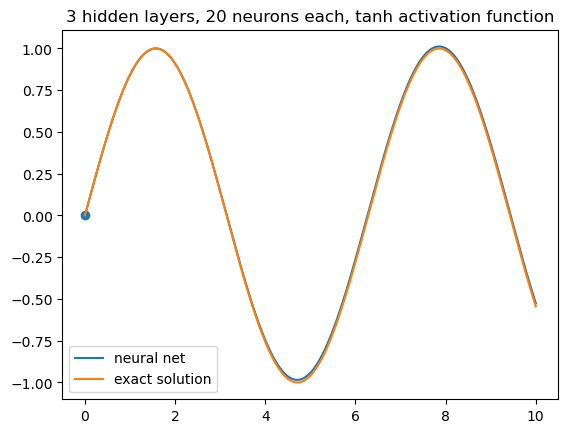

In [12]:
t_test=np.linspace(0,10,200).reshape(200,1) #time interval for test
pt_t_test = Variable(torch.from_numpy(t_test).float(), requires_grad=False).to(device) #as pytorch variable
u_test=model(pt_t_test) #solve DGL with PINN
plt.plot(t_test,u_test.detach().numpy()) #plot
plt.plot(t_test, np.sin(t_test))
plt.scatter(0,0)
plt.title('3 hidden layers, 20 neurons each, tanh activation function')
plt.legend(['neural net','exact solution'])